In [48]:
import pandas as pd
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pingouin as pg

In [2]:
groups = pd.read_csv('C:/Users/elnur/Downloads/Проект_2_groups.csv', sep=';')
group_add = pd.read_csv('C:/Users/elnur/Downloads/Проект_2_group_add.csv')
active_studs = pd.read_csv('C:/Users/elnur/Downloads/Проект_2_active_studs.csv')
checks = pd.read_csv('C:/Users/elnur/Downloads/Проект_2_checks.csv', sep=';')

# Подготовка данных

In [31]:
#Посчитал пользователей активных и с оплатой
active_payed = active_studs.merge(checks, on='student_id', how='inner')
#Посчитал пользователей не активных и с оплатой
payed_not_active = checks[~checks['student_id'].isin(active_studs['student_id'])]

In [30]:
payed_not_active.shape[0]

149

In [35]:
#Оставил только тех кто зашли на платформу
df = pd.merge(groups, active_studs, left_on='id', right_on='student_id', how='inner')
df = df[['student_id', 'grp']]

In [36]:
#Добавил столбец с оплатой в дни эксперимента 
df = pd.merge(df, checks, on='student_id', how='left')

In [37]:
#Заменил null нулем
df['rev'] = df['rev'].fillna(0)

In [38]:
checks.student_id.nunique()

541

In [7]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

## Метрики анализа

Новая механика оплаты может влиять двумя способами. Во-первых, она может увеличить количество пользователей, которые решаются оплатить (смотрим **конверсию**). Во-вторых, она может быть удобнее для определённой аудитории — тогда сами платящие начинают платить чаще или больше (смотрим **ARPPU**).

# Проверка CR

H0: Новый способ оплаты не повлияла на конверсию.

H1: Новый способ оплаты повлияла на конверсию.

Для проверки на стат значимость использую метод **хи-квадрат**, так как данные **категориальные**

In [40]:
#Считаю общ кол по группам и кол тех кто совершил оплату
group_a_st_count = df.query("grp == 'A'").student_id.nunique()
group_a_st_count_paid = df.query("grp == 'A' and rev != 0").student_id.nunique()

group_b_st_count = df.query("grp == 'B'").student_id.nunique()
group_b_st_count_paid = df.query("grp == 'B' and rev != 0").student_id.nunique()

In [41]:
#Считаю конверсию по группам
cr_group_a = group_a_st_count_paid*100 / group_a_st_count
cr_group_b = group_b_st_count_paid*100 / group_b_st_count

print(cr_group_a, cr_group_b)

5.0814332247557 4.607684380980421


In [42]:
# строим contingency table
data = [[group_a_st_count_paid, group_a_st_count - group_a_st_count_paid], [group_b_st_count_paid, group_b_st_count - group_b_st_count_paid]]

In [43]:
#Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(data)

print("Chi2:", chi2)
print("p-value:", p)

Chi2: 0.526607176998989
p-value: 0.46803677583199144


In [71]:
if p < 0.05:
    print("Отклоняем нулевую гипотезу")
    print("H1: Новый способ оплаты повлияла на конверсию.")
else:
    print("Отклоняем альтернативную гипотезу")
    print("H0: Новый способ оплаты не повлияла на конверсию.")

Отклоняем альтернативную гипотезу
H0: Новый способ оплаты не повлияла на конверсию.


# Проверка ARPPU

H0: Новый способ оплаты не повлиял на средний доход с платящего пользоватя

H1: Новый способ оплаты повлиял на средний доход с платящего пользоватя

**Так как груп у нас два и мы сравниваем средние в этих группах буду использовать T-критерий**

In [59]:
#Добавил принадлежность к группам
active_payed = active_payed.merge(groups, left_on='student_id', right_on='id', how='inner')
active_payed = active_payed[['student_id', 'rev', 'grp']]

In [67]:
#Проверил на нормальность 
pg.normality(data=active_payed, dv="rev", group="grp", method="shapiro")

,W,pval,normal
grp,,,
A,0.735324,1.498692e-10,False
B,0.855196,1.756240e-16,False


In [68]:
#Проверил на равенство дисперсий
pg.homoscedasticity(data=active_payed, dv='rev', group='grp')

,W,pval,equal_var
levene,3.055864,0.081235,True


In [69]:
#Считаю arppu по группам
arppu_a = df.query("grp == 'A' and rev > 0").rev.mean()

arppu_b = df.query("grp == 'B' and rev > 0").rev.mean()

print(arppu_a, arppu_b)

933.5897435897435 1255.8274872204472


<Axes: xlabel='rev', ylabel='Count'>

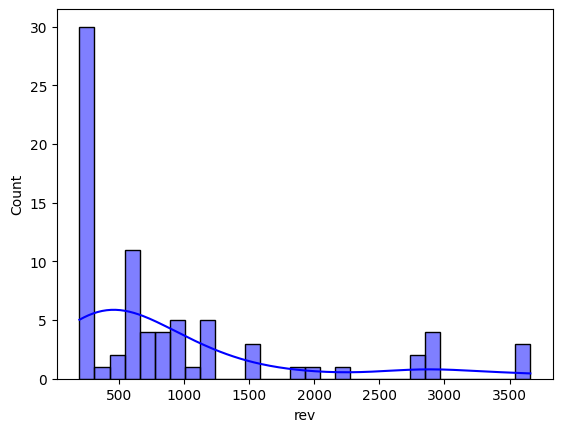

In [46]:
sns.histplot(df.query("grp == 'A' and rev > 0").rev, kde=True, color="blue", label="A", bins=30)

<Axes: xlabel='rev', ylabel='Count'>

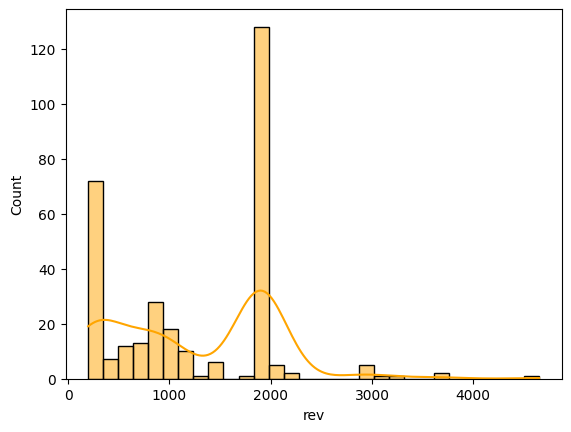

In [47]:
sns.histplot(df.query("grp == 'B' and rev > 0").rev, kde=True, color="orange", label="B", bins=30)

In [72]:
pg.ttest(
    x=active_payed.query("grp == 'A'")['rev'],
    y=active_payed.query("grp == 'B'")['rev'],
    correction=False,
    paired=False,      
    alternative='two-sided' 
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.111439,389,two-sided,0.001999,"[-525.86, -118.62]",0.393759,13.12,0.873644


p-value меньше 0.05, Отклоняем нулевую гипотезу 

# Вывод

Эффекта на CR нет, это доказывает критерий хи-квадрат

Есть положительный эффект на ARPPU, t-критерий подтверждает изменения

Новый способ оплаты увеличил ARPPU на 34,5%, изменение оказалось статестический значимым 

Измененией обеспечено засчет тех кто совершал оплату на сумму ровно 1900. Если получиться определить этот сегмент аудитории, и если мы уверены что новая механика не влияет(положительно) на другие сегменты, то в таком случае можно ограничить введение новой механики целевым сегментом. Если не получиться выполнить эти два условия то стоит вводить изменение на всех

# Задание 3. Python

In [61]:
#Ищет фаил с названием groups_add.csv в папке Downloads
def load_groups_add():
    downloads_path = os.path.join(os.environ.get('USERPROFILE') or os.environ.get('HOME'), 'Downloads')
    file_path = os.path.join(downloads_path, 'groups_add.csv')
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print("Файл groups_add.csv не найден в Downloads")
        return pd.DataFrame()  # пустой df, если файла нет

def ab_test(groups):
    # --- Чтение нового df ---
    df = load_groups_add()
    if df.empty:
        print("Новый CSV пустой, используем только groups")
        df = groups.copy()
    else:
        # Нормализация названий колонок
        new_names = {}
        for col in df.columns:
            series = df[col]
            if series.nunique() == len(series):
                new_names[col] = "id123"
            elif set(series.unique()) <= {"A", "B"}:
                new_names[col] = "grp"
            else:
                raise ValueError(f"Не удалось определить колонку: {col}")
        df = df.rename(columns=new_names)
        # Объединение с основным groups
        df = pd.concat([groups, df], ignore_index=True)

    # --- Фильтрация и подготовка ---
    df = pd.merge(df, active_studs, left_on='id', right_on='student_id', how='inner')
    df = pd.merge(df, checks, left_on='id', right_on='student_id', how='left')
    df = df[['id', 'grp', 'rev']]
    df['rev'] = df['rev'].fillna(0)

    # --- A/B тест ---
    group_a_count = df.query("grp == 'A'").id.nunique()
    group_a_paid = df.query("grp == 'A' and rev != 0").id.nunique()

    group_b_count = df.query("grp == 'B'").id.nunique()
    group_b_paid = df.query("grp == 'B' and rev != 0").id.nunique()

    cr_a = group_a_paid * 100 / group_a_count
    cr_b = group_b_paid * 100 / group_b_count

    data = [
        [group_a_paid, group_a_count - group_a_paid],
        [group_b_paid, group_b_count - group_b_paid]
    ]
    chi2, p, dof, expected = chi2_contingency(data)

    # ARPPU
    ratio = (df.query("grp == 'B' and rev > 1850 and rev < 1950").rev.value_counts().sum() 
             / df.query("grp == 'B' and rev > 0").shape[0]) * 100

    arppu_a = df.query("grp == 'A' and rev > 0").rev.mean()
    arppu_b = df.query("grp == 'B' and rev > 0").rev.mean()

    group_a_rev = df.query("grp == 'A' and rev > 0").rev
    group_b_rev = df.query("grp == 'B' and rev > 0").rev

    stat, p_value = mannwhitneyu(group_b_rev, group_a_rev, alternative='greater')

    # --- Визуализация ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].bar(["Группа A", "Группа B"], [cr_a, cr_b], color=["turquoise", "salmon"])
    axes[0].set_title("Конверсия по группам в %")
    axes[1].bar(["Группа A", "Группа B"], [arppu_a, arppu_b], color=["turquoise", "salmon"])
    axes[1].set_title("ARPPU по группам")
    plt.tight_layout()
    plt.show()

    results = {
        "Конверсия в группе А": cr_a,
        "Конверсия в группе Б": cr_b,
        "P-value конверсии": p,
        "Доля покупателей в % на сумму 1900": ratio,
        "ARPPU в группе А": arppu_a,
        "ARPPU в группе Б": arppu_b,
        "P-value arppu": p_value
    }
    return results

Файл groups_add.csv не найден в Downloads
Новый CSV пустой, используем только groups


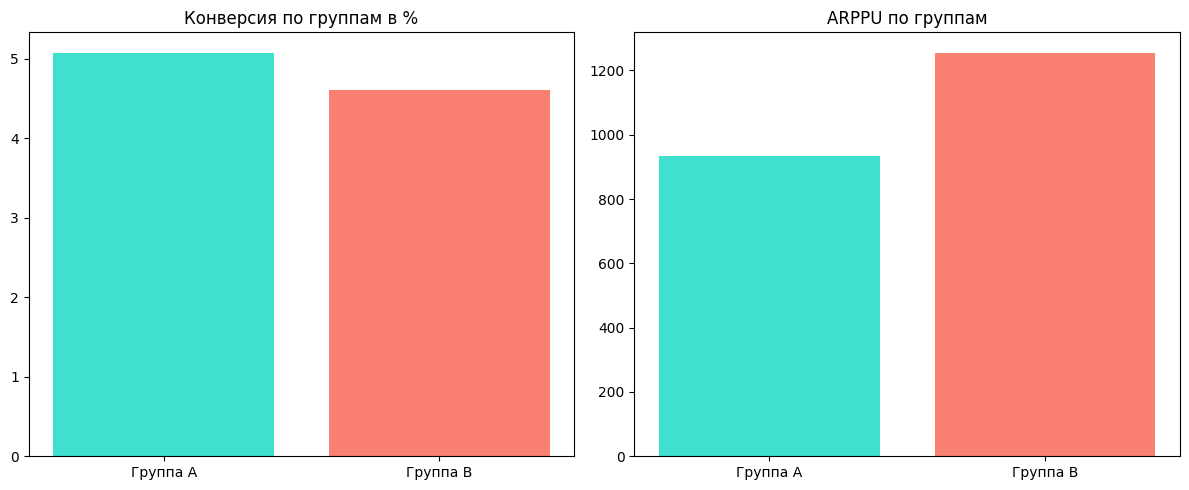

{'Конверсия в группе А': 5.0814332247557,
 'Конверсия в группе Б': 4.607684380980421,
 'P-value конверсии': np.float64(0.46803677583199144),
 'Доля покупателей в % на сумму 1900': np.float64(40.57507987220447),
 'ARPPU в группе А': np.float64(933.5897435897435),
 'ARPPU в группе Б': np.float64(1255.8274872204472),
 'P-value arppu': np.float64(0.0001366223502529715)}

In [62]:
ab_test(groups)